In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

In [15]:
# # clear shared RAM (Colab shares RAM and GPU with other user sessions, this guarantees all resources allocated to this session)
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil --quiet
# !pip install psutil --quiet
# !pip install humanize --quiet
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # only one GPU on Colab and isn't guaranteed
# gpu = GPUs[0]
# proc = psutil.Process(os.getpid())
# print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " | Proc size: " + humanize.naturalsize(proc.memory_info().rss))
# print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [16]:
import numpy as np
import pandas as pd
import torch
import torchvision as tv
import re
import time
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Module, GRU, Embedding, Linear, Sigmoid, CrossEntropyLoss, ReLU, Tanh, Sequential
from torch import nn
from torchvision import transforms
import torch.optim as optim
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
import copy
matplotlib.style.use('ggplot')

In [17]:
# learning parameters
batch_size = 1024
epochs = 200
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

fmnist = datasets.FashionMNIST(root='./', train=True, download=True, transform=transform)
data_loader = DataLoader(fmnist, batch_size=batch_size, shuffle=True)

In [19]:
class Generator(Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = Sequential(
            Linear(self.nz, 256),
            ReLU(),

            Linear(256, 512),
            ReLU(),

            Linear(512, 784),
            Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)


class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = Sequential(
            Linear(self.n_input, 1024),
            ReLU(),
            Linear(1024, 512),
            ReLU(),
            Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

    def load(self, backup):
        for m_from, m_to in zip(backup.modules(), self.modules()):
            if isinstance(m_to, nn.Linear):
                m_to.weight.data = m_from.weight.data.clone()
                if m_to.bias is not None:
                    m_to.bias.data = m_from.bias.data.clone()    

Initialize the Neural Networks and Define the Optimizers

In [20]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
######################


In [24]:
# loss function
criterion = nn.BCELoss()

# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)
# noise generator
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake, discriminator, create_graph=False):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    # loss_real.backward()
    # loss_fake.backward()
    loss = loss_fake + loss_real
    loss.backward(create_graph=create_graph)
    optimizer.step()
    return loss.item()

# function to train the generator network
def train_generator(optimizer, data_fake, discriminator):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss.item()

In [25]:
# create the noise vector
noise = create_noise(sample_size, nz)
generator.train()
discriminator.train()

# path = "/content/drive/MyDrive/Deep_Learning/HW3/outputs_unrolled_gan/"
path = "./models/unrolled/"
epochs = 200
k = 1

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
losses_ud = []
images = [] # to store images generatd by the generator
length = 0.

for epoch in range(epochs):
    start = time.time()
    # length = 0.
    loss_g = 0.0
    loss_d = 0.0
    loss_ud = 0.
    for bi, data in enumerate(data_loader):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        
        
        # print(create_noise(b_size, nz).shape)
        data_fake = generator(create_noise(b_size, nz)).detach()
        data_real = image
        # train the discriminator network
        loss_d += train_discriminator(optim_d, data_real, data_fake, discriminator)
        
        # unroll
        backup = copy.deepcopy(discriminator)
        # run the unrolled discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            loss_ud += train_discriminator(optim_d, data_real, data_fake, discriminator, create_graph=True)
            
        # data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        data_fake = generator(create_noise(b_size, nz)).detach()
        loss_g += train_generator(optim_g, data_fake, discriminator)
        discriminator.load(backup)
        del backup

        
    # create the final fake image for the epoch
    if epoch%1==0:
        generated_img = generator(noise).cpu().detach()
        # make the images as grid
        generated_img = make_grid(generated_img)
        # save the generated torch tensor models to disk
        save_generator_image(generated_img, path + f"gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    epoch_loss_ud = loss_ud / (bi*k)
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    losses_ud.append(epoch_loss_ud)
    end = time.time() - start
    length += end
    mean_so_far = length / (epoch+1)
    time_left = (mean_so_far * (epochs - epoch - 1))/60
    
    print(f"Epoch {epoch} of {epochs}:\t\t{end:.2f} seconds;\ttotal: {length:.2f};\tminutes left: {time_left:.2f}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.5f}, Unrolled Discriminator loss: {epoch_loss_ud:.5f}")

Epoch 0 of 200:		39.60 seconds;	total: 39.60;	minutes left: 131.33
Generator loss: 13.71178711, Discriminator loss: 0.00002, Unrolled Discriminator loss: 0.00002
Epoch 1 of 200:		40.61 seconds;	total: 80.20;	minutes left: 132.33
Generator loss: 15.45526204, Discriminator loss: 0.00000, Unrolled Discriminator loss: 0.00000
Epoch 2 of 200:		41.25 seconds;	total: 121.45;	minutes left: 132.92
Generator loss: 16.28300037, Discriminator loss: 0.00000, Unrolled Discriminator loss: 0.00000
Epoch 3 of 200:		41.35 seconds;	total: 162.80;	minutes left: 132.96
Generator loss: 16.85951986, Discriminator loss: 0.00000, Unrolled Discriminator loss: 0.00000
Epoch 4 of 200:		41.61 seconds;	total: 204.41;	minutes left: 132.87
Generator loss: 17.33162081, Discriminator loss: 0.00000, Unrolled Discriminator loss: 0.00000
Epoch 5 of 200:		42.08 seconds;	total: 246.49;	minutes left: 132.83
Generator loss: 17.69593607, Discriminator loss: 0.00000, Unrolled Discriminator loss: 0.00000
Epoch 6 of 200:		43.24 s

KeyboardInterrupt: 

In [24]:
discriminator

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [21]:
print('DONE TRAINING')
torch.save(generator.state_dict(), path + 'generator.pth')
path

DONE TRAINING


'/content/drive/MyDrive/Deep_Learning/HW3/outputs_unrolled_gan/'

In [22]:
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave(path + 'generator_images.gif', imgs)

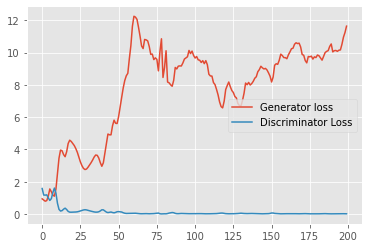

In [25]:
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
# plt.savefig(path + 'loss.png')